In [189]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.datasets import load_digits
digits = load_digits()
images = np.load('../test_windows.npy')

### Introduction
Using a stack of images consisting of regions surrounding detected patterns on Hi-C maps.
All patterns should represent the same type (e.g. chromatin loop), but some are false positives.
The idea is to exclude the false positive based on their appearance.

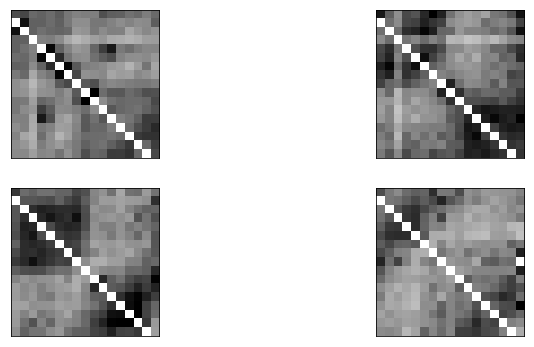

In [190]:
%matplotlib inline
import matplotlib.pyplot as plt
r = c = int(np.floor(np.sqrt(images.shape[0])))
fig, axes = plt.subplots(r, c, figsize=(12, 6), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i, :, :], cmap=plt.cm.gray_r, interpolation='nearest')
    #ax.text(1, 1, str(digits.target[i]), transform=ax.transAxes, color='blue')

### Preprocessing
Patterns should be comparable so we need to correct for baseline signal due to local background and smooth noisy regions out.

In [191]:
import scipy.ndimage as ndi
for i in range(images.shape[0]):
    m = images[i, :, :].copy()
    images[i, :, :] -= np.mean(m)
    images[i, :, :] /= np.std(m)
    
images = ndi.gaussian_filter(images, sigma=1)

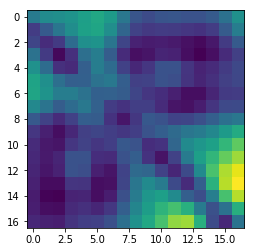

In [192]:
plt.imshow(images[0, :, :])

### Clustering

For now I use k-means clustering, but ideally we should use a clustering algorithm such as DBSCAN that does not required prior knowledge of the number of clusters.


In [193]:
n, x, y = images.shape

data = np.reshape(images, (n, x*y))

In [194]:
from sklearn.cluster import SpectralClustering
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
n_clusters = 3
d_cl = KMeans(n_clusters=n_clusters, n_init=100)
pred = d_cl.fit_predict(data)

Using matplotlib backend: Qt5Agg


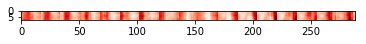

In [195]:
%matplotlib 

plt.imshow(data, cmap="Reds")

Cluster centroids can be visualized to identify which clusters represent patterns of interest, or simply noise from various types of false positive signals.

Green windows are patterns that clustered with the main cluster (largest) and red are those that did not. K-means clustering does not work so well apparently. Perhaps we can fix that by combining a naive clustering method and PCA....

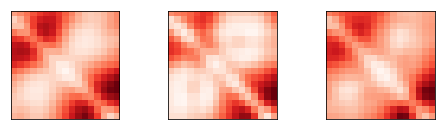

In [196]:
# Visualise cluster centroid (pixels are dimensions) to see "typical number" in cluster
#plt.figure(figsize=(100,100))
f, axes = plt.subplots(1, n_clusters, figsize=(8, 2), subplot_kw=dict(xticks=[], yticks=[]))
for ax, i in zip(axes.flat, range(d_cl.cluster_centers_.shape[0])):
    centroid = np.reshape(d_cl.cluster_centers_[i, :], (x, y))
    ax.imshow(centroid, cmap='Reds')

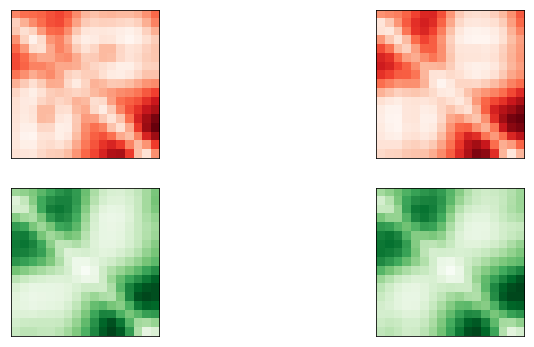

In [197]:
%matplotlib inline
clusters, counts = np.unique(d_cl.labels_, return_counts=True)
largest_cluster = clusters[np.where(counts == max(counts))[0]][0]
largest_cluster

fig, axes = plt.subplots(r, c, figsize=(12, 6), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    if d_cl.labels_[i] == largest_cluster:
        cmap="Greens"
    else:
        cmap="Reds"
    ax.imshow(images[i, :, :], cmap=cmap, interpolation='nearest')
    #ax.text(1, 1, str(digits.target[i]), transform=ax.transAxes, color='blue')


### Reducing dimensions
Reducing dimensions could allow separating noise from information in those windows and make the clustering more stable.

In [198]:
from sklearn.decomposition import PCA

def pca_transform(data, n=8):
    pca = PCA(n_components=n, random_state=1)
    pca.fit(data)
    evar = pca.explained_variance_ratio_.sum()
    pcas = pca.transform(data)
    reduced = pca.inverse_transform(pcas)
    return reduced, pcas, evar

First, we need to estimate the number of principal components required to retain a target proportion of variance. We'll consider we want to keep 70% of pixel variance

Text(10, 0.2, 'n=3\np=0.95')

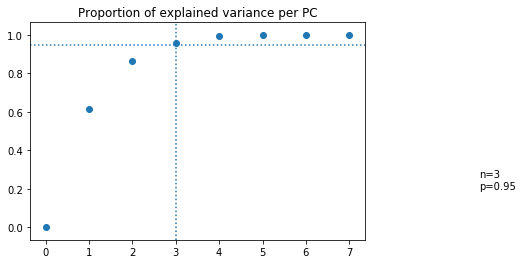

In [199]:
%matplotlib inline
pc_range = n
expl_var = [0 for i in range(pc_range)]
for i in range(pc_range):
    _, _, v = pca_transform(data, n=i)
    expl_var[i] = v
    
target_prop = 0.95
diff_expl = np.abs(np.array(expl_var) - target_prop)
n_pc_req = np.where(diff_expl == min(diff_expl))[0][0]
plt.scatter(range(len(expl_var)), expl_var)
plt.axhline(y=target_prop, ls=':')
plt.axvline(x=n_pc_req, ls=':')
plt.title("Proportion of explained variance per PC")
plt.text(x=10, y=0.2, s=f"n={n_pc_req}\np={target_prop}")

In [200]:
reduced, pcas, evar = pca_transform(data, n=n_pc_req)

We can then use the invert PCA transform to convert images back from PC space to pixel space. This will yield "simplified" images with some of the variance removed.

In [201]:
n_clusters = 2
d_cl = KMeans(n_clusters=n_clusters, n_init=100)
pred = d_cl.fit_predict(reduced)

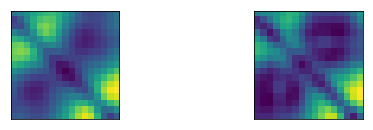

In [202]:
# Visualise cluster centroid (pixels are dimensions) to see "typical number" in cluster
#plt.figure(figsize=(100,100))
f, axes = plt.subplots(1, n_clusters, figsize=(8, 2), subplot_kw=dict(xticks=[], yticks=[]))
for ax, i in zip(axes.flat, range(d_cl.cluster_centers_.shape[0])):
    centroid = np.reshape(d_cl.cluster_centers_[i, :], (x, y))
    ax.imshow(centroid)

The pattern characteristic is actually made more apparent by only keeping a few PC since it should be the most obvious characteristic in the dataset. This should make it easier to tell false positives from real patterns

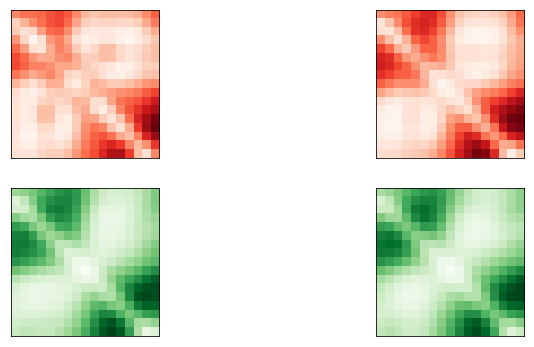

In [203]:
%matplotlib inline
clusters, counts = np.unique(d_cl.labels_, return_counts=True)
largest_cluster = clusters[np.where(counts == max(counts))[0]][0]
largest_cluster

fig, axes = plt.subplots(r, c, figsize=(12, 6), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    if d_cl.labels_[i] == largest_cluster:
        cmap="Greens"
    else:
        cmap="Reds"
    
    ax.imshow(np.reshape(reduced[i, :], (x, y)), cmap=cmap, interpolation='nearest')

PC1 clearly dominates the variance and likely contain the 'looping' information. K-means is simply not appropriate for this. We need to be able to identify bimodality.

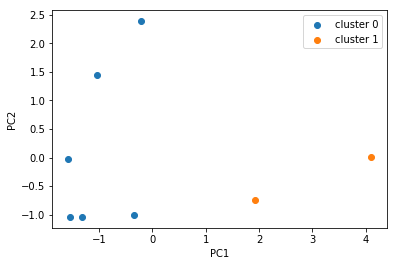

In [204]:
pc_a, pc_b = 0, 1
fig, ax1 = plt.subplots()
for i in range(len(d_cl.cluster_centers_)):
    cl_points = d_cl.labels_ == i
    ax1.scatter(pcas[cl_points, pc_a], pcas[cl_points, pc_b], label=f'cluster {i}')
plt.xlabel(f'PC{pc_a+1}')
plt.ylabel(f'PC{pc_b+1}')
plt.legend()


### Alternative to clustering
Since choosing the number of centroids is not desirable and parameters 

### Interactive visualisation


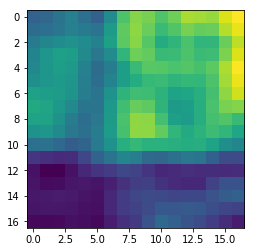

In [184]:
from bokeh.plotting import figure, output_file, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool
from tempfile import mkdtemp
from os.path import join
def build_source(x_data, y_data, images):
    img_dir = mkdtemp()
    imgs = ['' for i in range(images.shape[0])]
    for i, v in enumerate(images):
        imgs[i] = join(img_dir, f"pattern_{i}.png")
        plt.imshow(v)
        plt.savefig(imgs[i])
    source = ColumnDataSource(
            data=dict(
                x=x_data,
                y=y_data,
                desc=list(range(len(x_data))),
                imgs = imgs
            )
        )
    return source

source = build_source(pcas[:, 0], pcas[:, 1], images)

In [185]:
output_file("toolbar.html")
#output_notebook()


hover = HoverTool(
        tooltips="""
        <div>
            <div>
                <img
                    src="@imgs" height="90" alt="@imgs" width="90"
                    style="float: left; margin: 0px 15px 15px 0px;"
                    border="2"
                ></img>
            </div>
            <div>
                <span style="font-size: 17px; font-weight: bold;">@desc</span>
                <span style="font-size: 15px; color: #966;">[$index]</span>
            </div>
            <div>
                <span style="font-size: 15px;">Location</span>
                <span style="font-size: 10px; color: #696;">($x, $y)</span>
            </div>
        </div>
        """
    )

p = figure(plot_width=800, plot_height=800, tools=[hover],
           title="Detected patterns in PC space")
p.xaxis.axis_label = f'PC{pc_a+1}'
p.yaxis.axis_label = f'PC{pc_b+1}'
p.circle('x', 'y', size=20, source=source)

show(p)

In [6]:
#df_lab = pd.DataFrame(
#    np.vstack([pred, digits.target]).T, 
#    columns=["pred", "target"])
#df_lab.groupby(['pred', 'target']).count()

In [350]:
# Guess match between guessed classes and actual target
#import pandas as pd
#df_lab = pd.DataFrame(
#    np.vstack([pred, digits.target]).T, 
#    columns=["pred", "target"])
#df_lab['best_match'] = df_lab.groupby('target').apply(
#    lambda g: np.bincount(g.pred).argmax())
#df_lab['match_strength'] = df_lab.groupby('target').apply(
#    lambda g: np.max(np.bincount(g.pred)))